# Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import category_encoders as ce

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import anderson

import tensorflow as tf

# Data

Data is taken from Kaggle (https://www.kaggle.com/datasets/muhammadbinimran/housing-price-prediction-data).

In [2]:
df = pd.read_csv("housing_price_dataset.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   SquareFeet    50000 non-null  int64  
 1   Bedrooms      50000 non-null  int64  
 2   Bathrooms     50000 non-null  int64  
 3   Neighborhood  50000 non-null  object 
 4   YearBuilt     50000 non-null  int64  
 5   Price         50000 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 2.3+ MB


In [4]:
df.head()

,SquareFeet,Bedrooms,Bathrooms,Neighborhood,YearBuilt,Price
0,2126,4,1,Rural,1969,215355.283618
1,2459,3,2,Rural,1980,195014.221626
2,1860,2,1,Suburb,1970,306891.012076
3,2294,2,1,Urban,1996,206786.787153
4,2130,5,2,Suburb,2001,272436.239065


# Feature Manipulation

Other than square feet and price, the other numeric features are all discrete and are thus converted to a categorical data type:

In [5]:
for col in ["Bedrooms","Bathrooms","Neighborhood","YearBuilt"]:
    df[col] = pd.Categorical(df[col])

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   SquareFeet    50000 non-null  int64   
 1   Bedrooms      50000 non-null  category
 2   Bathrooms     50000 non-null  category
 3   Neighborhood  50000 non-null  category
 4   YearBuilt     50000 non-null  category
 5   Price         50000 non-null  float64 
dtypes: category(4), float64(1), int64(1)
memory usage: 979.8 KB


# Data Exploration

#### Numeric features:

In [7]:
df.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
SquareFeet,50000.0,2006.37,575.51,1000.00,1513.00,2007.00,2506.00,2999.00
Price,50000.0,224827.33,76141.84,-36588.17,169955.86,225052.14,279373.63,492195.26


Some of the prices are negative, which cannot be the case, and are thus removed:

In [8]:
df = df[df.Price > 0]

Correlation matrix:

In [9]:
df.corr(numeric_only=True).round(2)

,SquareFeet,Price
SquareFeet,1.00,0.75
Price,0.75,1.00


Strong positive correlation between price and square feet, which is to be expected.

#### Non-numeric features:

Counts by number of bedrooms:

In [10]:
df.Bedrooms.value_counts().sort_index()

2    12431
3    12656
4    12429
5    12462
Name: Bedrooms, dtype: int64

Very evenly distributed between 2-5 bedrooms.

And bathrooms:

In [11]:
df.Bathrooms.value_counts().sort_index()

1    16747
2    16711
3    16520
Name: Bathrooms, dtype: int64

Also very evenly distributed.

Likely that there is a positive correlation between bedrooms and bathrooms:

In [12]:
df[["Bedrooms","Bathrooms"]].value_counts().sort_index()

Bedrooms  Bathrooms
2         1            4227
          2            4180
          3            4024
3         1            4262
          2            4180
          3            4214
4         1            4113
          2            4181
          3            4135
5         1            4145
          2            4170
          3            4147
dtype: int64

Interestingly no, there is a very even distribution again between all combinations of bedrooms and bathrooms.

See how the numeric features vary with bedroom and bathroom combinations:

In [13]:
df.groupby(["Bedrooms","Bathrooms"]).mean(numeric_only=True).round()

SquareFeet     Price
Bedrooms Bathrooms                      
2        1              2020.0  215781.0
         2              2010.0  218669.0
         3              2004.0  220631.0
3        1              2004.0  219352.0
         2              2006.0  221374.0
         3              1995.0  222750.0
4        1              2015.0  224690.0
         2              2003.0  227533.0
         3              2014.0  230524.0
5        1              1996.0  228697.0
         2              2011.0  234070.0
         3              2004.0  235369.0

Average price increases with bathrooms irrespective of bedrooms, but square feet does not have a consistent pattern. For 2 bedroom houses, as the number of bathrooms increases the average square feet decreases, while for the other numbers of bedrooms there is no consistent pattern of square feet by bathrooms.

Next is neighborhood:

In [14]:
df.Neighborhood.value_counts()

Suburb    16716
Rural     16668
Urban     16594
Name: Neighborhood, dtype: int64

Evenly distributed again.

See if there is a difference in bedrooms by neighborhood as may expect more bedrooms in rural and suburban areas due to there being more space:

In [15]:
df[["Neighborhood","Bedrooms"]].value_counts().sort_index()

Neighborhood  Bedrooms
Rural         2           4117
              3           4170
              4           4199
              5           4182
Suburb        2           4137
              3           4306
              4           4157
              5           4116
Urban         2           4177
              3           4180
              4           4073
              5           4164
dtype: int64

Clearly this theory is not the case in this data set.

Again, see how the numeric features are impacted by neighborhood:

In [16]:
df.groupby("Neighborhood").mean(numeric_only=True).round(2)

,SquareFeet,Price
Neighborhood,,
Rural,2002.02,224209.37
Suburb,2000.41,223302.97
Urban,2017.89,227297.86


Interestingly, square feet is larger for urban on average than the other two neighborhoods, where there is traditionally more space to build larger housing. The average prices are quite similar for each neighborhood.

Finally, there is the year the house was built:

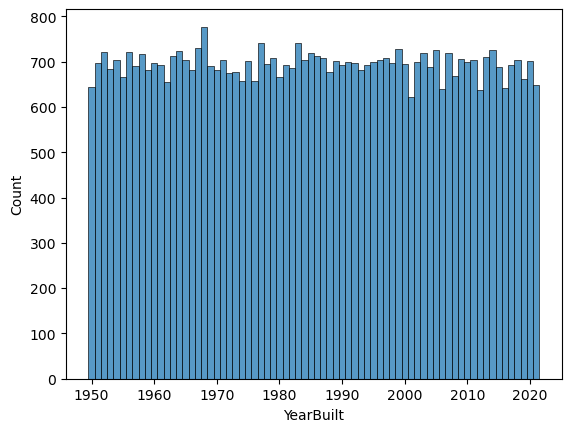

In [17]:
sns.histplot(df.YearBuilt, discrete=True)
plt.show()

No notable difference in number of houses by year built, with between 600-800 houses for each year in the data.

Plot average price by year built (with confidence intervals):

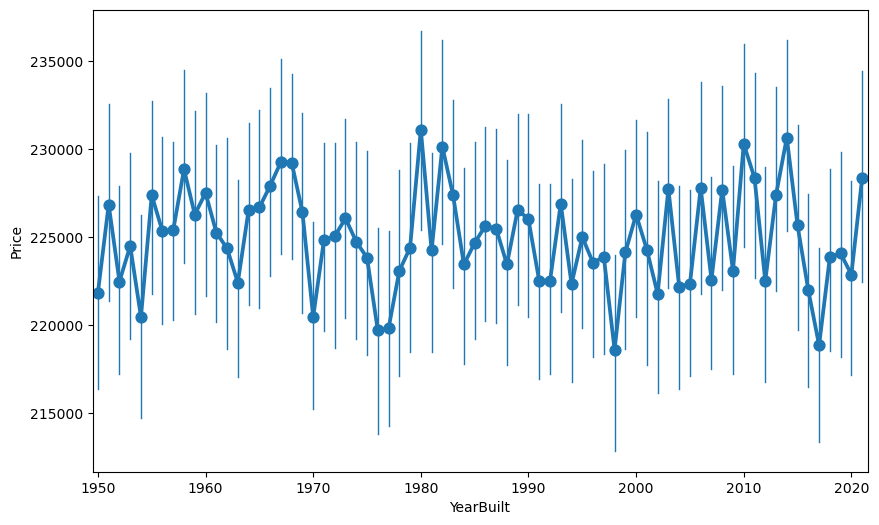

In [18]:
f,a = plt.subplots(figsize=(10,6))

sns.pointplot(x=df.YearBuilt, y=df.Price, ax=a, err_kws={"linewidth":1})
a.set_xticks(np.arange(min(a.get_xticks()), max(a.get_xticks()), 10))

plt.show()

Doesn't seem to be an overall trend but some significant variation.

# Modelling

The methods used to predict house prices are:

- Linear regression.
- Random forest regression.
- Deep neural network regression.

## Linear Regression

To use the categorical features in a linear regression they will need to be coded as dummy variables. Due to year built having so many possible values, it will be encoded using a binary encoder. This will reduce the interpretability of its coefficients, but greatly improve fitting times.

Additionally, square feet and price are scaled to be between 0 and 1 based on their minimum and maximum values.

In [19]:
df_lr = pd.get_dummies(df, columns=["Bedrooms","Bathrooms","Neighborhood"], drop_first=True)

YearBuilt_encoder = ce.BinaryEncoder()

SquareFeet_scaler = MinMaxScaler()
Price_scaler = MinMaxScaler()

df_lr = pd.concat([
    pd.DataFrame(Price_scaler.fit_transform(df_lr[["Price"]]), columns=["Price"]),
    pd.DataFrame(SquareFeet_scaler.fit_transform(df_lr[["SquareFeet"]]), columns=["SquareFeet"]),
    df_lr.drop(["SquareFeet","Price","YearBuilt"], axis="columns").reset_index(drop=True),
    YearBuilt_encoder.fit_transform(df_lr.YearBuilt).reset_index(drop=True)
], axis="columns")

df_lr.head()

,Price,SquareFeet,Bedrooms_3,Bedrooms_4,Bedrooms_5,Bathrooms_2,Bathrooms_3,Neighborhood_Suburb,Neighborhood_Urban,YearBuilt_0,YearBuilt_1,YearBuilt_2,YearBuilt_3,YearBuilt_4,YearBuilt_5,YearBuilt_6
0,0.437363,0.563282,0,1,0,0,0,0,0,0,0,0,0,0,0,1
1,0.396023,0.729865,1,0,0,1,0,0,0,0,0,0,0,0,1,0
2,0.623396,0.430215,0,0,0,0,0,1,0,0,0,0,0,0,1,1
3,0.419949,0.647324,0,0,0,0,0,0,1,0,0,0,0,1,0,0
4,0.553372,0.565283,0,0,1,1,0,1,0,0,0,0,0,1,0,1


A sequential feature selector is used to optimise the performance of the model while reducing complexity, by greedily fitting the model with each variable combination and calculating the mean squared error before selecting the model with the lowest mean squared error:

In [20]:
lr_feature_select = SequentialFeatureSelector(
        linear_model.LinearRegression(), n_features_to_select="auto", direction="backward", scoring="neg_mean_squared_error"
    )

X_train, X_test, y_train, y_test = train_test_split(df_lr.drop("Price", axis="columns"), df_lr.Price, test_size=0.2, random_state=1)

lr_feature_select.fit(X_train, y_train)

print("Selected variables:", lr_feature_select.get_feature_names_out(), sep="\n")

Selected variables:
['SquareFeet' 'Bedrooms_3' 'Bedrooms_4' 'Bedrooms_5' 'Bathrooms_2'
 'Bathrooms_3' 'Neighborhood_Suburb' 'Neighborhood_Urban']


The selected variables are then used in the final model, which is evaluated using the root mean squared error of predictions and the R-squared coefficient:

In [21]:
lr = linear_model.LinearRegression()

lr.fit(lr_feature_select.transform(X_train), y_train)

lr_preds = lr.predict(lr_feature_select.transform(X_test))

print("""
RMSE:       {:.2f}
R-squared:  {:.2f}
""".format(mean_squared_error(Price_scaler.inverse_transform(pd.DataFrame(y_test)), Price_scaler.inverse_transform(pd.DataFrame(lr_preds)), squared=False),
           r2_score(y_test, lr_preds)))


RMSE:       49689.97
R-squared:  0.57



An R-squared score of 0.57 is not very good, and suggests there is a lot of variation in house price that the model is not capturing. This is also reflected in the rmse, which implies an average error of almost $50,000.

#### Check the assumptions of linear regression:

1. Linearity between dependent and independent variables.

We only have to check this for square feet since all other independent variables are dummy variables and thus will always have a linear relationship with price.

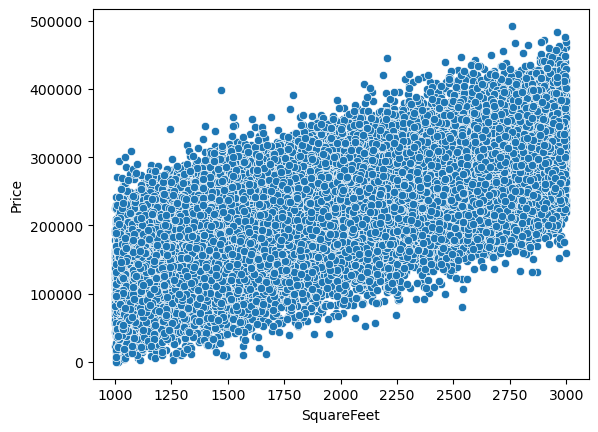

In [22]:
sns.scatterplot(df, x="SquareFeet", y="Price")
plt.show()

Clear linear relationship between the two variables, so this assumption holds.

2. No multicollinearity between independent variables.

To test this, the variance inflation factor is calculated for each of the independent variables:

In [23]:
{df_lr.drop("Price", axis="columns").columns[i]: variance_inflation_factor(df_lr.drop("Price", axis="columns"), i).round(2) for i in range(df_lr.shape[1] - 1)}

{'SquareFeet': 3.4,
 'Bedrooms_3': 1.8,
 'Bedrooms_4': 1.79,
 'Bedrooms_5': 1.78,
 'Bathrooms_2': 1.84,
 'Bathrooms_3': 1.83,
 'Neighborhood_Suburb': 1.83,
 'Neighborhood_Urban': 1.83,
 'YearBuilt_0': 1.37,
 'YearBuilt_1': 1.9,
 'YearBuilt_2': 1.91,
 'YearBuilt_3': 1.84,
 'YearBuilt_4': 1.88,
 'YearBuilt_5': 1.86,
 'YearBuilt_6': 1.87}

VIF values are low for each independent variable, so this assumption also holds.

3. Observations are independent.

To test this, a Durbin-Watson test is performed on the residuals of the model predictions.

In [24]:
print("Durbin-Watson Test Statistic:", durbin_watson(lr_preds - y_test).round(2))

Durbin-Watson Test Statistic: 2.0


A test statistic of 2 indicates the observations are indeed independent.

4. Homoscedasticity of residuals

To test this, the residuals are plotted to see if the variance of the residuals changes throughout the model.

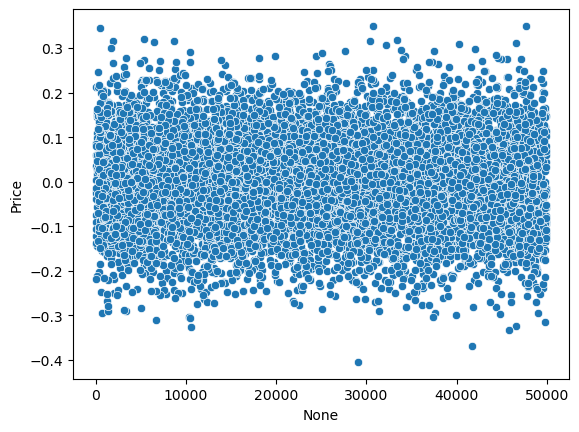

In [25]:
sns.scatterplot(x=y_test.index, y=(lr_preds - y_test))
plt.show()

The residuals are all evenly distributed around zero across the entire prediction range.

5. Normally distributed residuals

An Anderson-Darling test is performed to check this assumption.

In [26]:
print("Anderson-Darling test statistic:", anderson(lr_preds - y_test, dist="norm").statistic.round(3))
print("\nCritical Values\n", {str(anderson(lr_preds - y_test, dist="norm").significance_level[i]) + "%": anderson(lr_preds - y_test, dist="norm").critical_values[i] for i in range(5)})

Anderson-Darling test statistic: 0.58

Critical Values
 {'15.0%': 0.576, '10.0%': 0.656, '5.0%': 0.787, '2.5%': 0.918, '1.0%': 1.092}


 The test statistic is less than the 10% critical value, which suggests that there is insufficient evidence to support the claim that the residuals are not normally distributed.

Therefore, all five of the assumptions hold for this model.

## Random Forest Regression

To tune the hyperparameters of the random forest model, randomised search cross validation will be used. The hyperparameters that will be tuned are:

- `n_estimators`: number of trees in the forest.
- `max_depth`: maximum number of levels in each tree.
- `min_samples_split`: minimum number of observations in a node before it is split.
- `min_samples_leaf`: minimum number of observations allowed in a leaf node.

A benefit of a random forest model is that less preprocessing of the data is required. The cateogorical features can be left as they are except Neighborhood, which will be labelled numerically using an ordinal encoder. Moreover, price and square feet will still be scaled.

In [27]:
df_rf = pd.concat([
    pd.DataFrame(Price_scaler.transform(df[["Price"]]), columns=["Price"]),
    pd.DataFrame(SquareFeet_scaler.transform(df[["SquareFeet"]]), columns=["SquareFeet"]),
    df.drop(["Price","SquareFeet"], axis="columns").reset_index(drop=True)
], axis="columns")

Neighborhood_encoder = OrdinalEncoder()
df_rf["Neighborhood"] = Neighborhood_encoder.fit_transform(df_rf[["Neighborhood"]])
print("Neighborhood Encoding:\n", {i:Neighborhood_encoder.categories_[0][i] for i in range(3)})

X_train, X_test, y_train, y_test = train_test_split(df_rf.drop("Price", axis="columns"), df_rf.Price, test_size=0.2, random_state=1)

Neighborhood Encoding:
 {0: 'Rural', 1: 'Suburb', 2: 'Urban'}


Next, the grid for the randomized search will be set up before running 50 iterations of the randomised search to find the best performing model in terms of mean squared error.

In [28]:
%%time

rf = RandomForestRegressor()

grid = {
    "n_estimators": [50,100,200,500,1000],
    "max_depth": [3,5,20,50],
    "min_samples_split": [2,10,50],
    "min_samples_leaf": [2,5,10]
}

print("Search grid:\n", grid, "\n")

rf_search = RandomizedSearchCV(rf, grid, n_iter=50, cv=20, scoring="neg_mean_squared_error", random_state=1, n_jobs=-1)

rf_search.fit(X_train, y_train)

print("Best parameters:\n", rf_search.best_params_, "\n")

Search grid:
 {'n_estimators': [50, 100, 200, 500, 1000], 'max_depth': [3, 5, 20, 50], 'min_samples_split': [2, 10, 50], 'min_samples_leaf': [2, 5, 10]} 

Best parameters:
 {'n_estimators': 1000, 'min_samples_split': 10, 'min_samples_leaf': 10, 'max_depth': 5} 

CPU times: total: 36.4 s
Wall time: 2h 26min 44s


In [29]:
rf_preds = rf_search.predict(X_test)

print("""
RMSE:       {:.2f}
R-squared:  {:.2f}
""".format(mean_squared_error(Price_scaler.inverse_transform(pd.DataFrame(y_test)), Price_scaler.inverse_transform(pd.DataFrame(rf_preds)), squared=False),
           r2_score(y_test, rf_preds)))


RMSE:       49870.55
R-squared:  0.57



No improvement over the linear regression in terms of these evaluation metrics.

## Deep Neural Network Regression

To prepare the data for a neural network regression, the first step is to encode the categorical variables, which will be done in the same way as for the linear regression with a binary encoder for year built and dummy variables for the others. Moreover, square feet and price are normalized such that they have a mean of 0 and a standard deviation of one.

In [30]:
SquareFeet_standardizer = StandardScaler()
Price_standardizer = StandardScaler()

df_nn = pd.get_dummies(df, columns=["Bedrooms","Bathrooms","Neighborhood"], drop_first=True)

df_nn = pd.concat([
    pd.DataFrame(Price_standardizer.fit_transform(df[["Price"]]), columns=["Price"]),
    pd.DataFrame(SquareFeet_standardizer.fit_transform(df[["SquareFeet"]]), columns=["SquareFeet"]),
    df_nn.drop(["SquareFeet","Price","YearBuilt"], axis="columns").reset_index(drop=True),
    YearBuilt_encoder.fit_transform(df.YearBuilt).reset_index(drop=True)
], axis="columns")

df_nn.head()

,Price,SquareFeet,Bedrooms_3,Bedrooms_4,Bedrooms_5,Bathrooms_2,Bathrooms_3,Neighborhood_Suburb,Neighborhood_Urban,YearBuilt_0,YearBuilt_1,YearBuilt_2,YearBuilt_3,YearBuilt_4,YearBuilt_5,YearBuilt_6
0,-0.126013,0.207263,0,1,0,0,0,0,0,0,0,0,0,0,0,1
1,-0.393677,0.786046,1,0,0,1,0,0,0,0,0,0,0,0,1,0
2,1.078484,-0.255069,0,0,0,0,0,1,0,0,0,0,0,0,1,1
3,-0.238764,0.499262,0,0,0,0,0,0,1,0,0,0,0,1,0,0
4,0.625102,0.214215,0,0,1,1,0,1,0,0,0,0,0,1,0,1


Split into training and test data:

In [31]:
X_train, X_test, y_train, y_test = train_test_split(df_nn.drop("Price", axis="columns"), df_nn.Price, test_size=0.2, random_state=1)

Given the simplicity of the problem, only a simple neural network is needed. After the input layer, there is one hidden layer with 60 nodes before a single output layer giving the price prediction. More complex models were tested but yielded no improvement.

In [32]:
%%time

model = tf.keras.Sequential()

model.add(tf.keras.Input(shape=(X_train.shape[1],)))
model.add(tf.keras.layers.Dense(60, activation="relu"))
model.add(tf.keras.layers.Dense(1))

model.compile(loss="mean_squared_error", optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))

history = model.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), epochs=100, verbose=0)



CPU times: total: 6min 10s
Wall time: 4min 29s


Plot the loss versus validation loss:

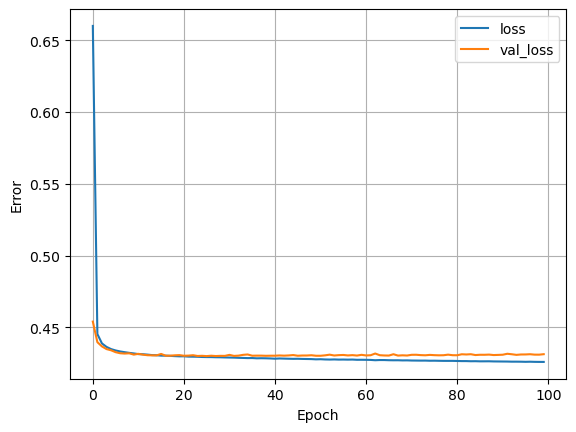

In [33]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.grid(True)

Evaluate performance:

In [34]:
nn_preds = model.predict(X_test)

print("""
RMSE:       {:.2f}
R-squared:  {:.2f}
""".format(mean_squared_error(Price_scaler.inverse_transform(pd.DataFrame(y_test)), Price_scaler.inverse_transform(pd.DataFrame(nn_preds)), squared=False),
           r2_score(y_test, nn_preds)))

313/313 [==============================] - 1s 2ms/step

RMSE:       323154.15
R-squared:  0.57



# Conclusions

The available data seems to be insufficient to construct a basic model with good predictive capabilities, since a RMSE of 50,000 is not great considering the prices are around 150,000 - 250,000, and an R-squared coefficient of close to 0.6 means there is a lot of variation in price that we cannot capture with the models and data we are using. 

It it likely that there are additional predictors that would improve the model's capabilities. For example, classifying neighborhoods into three broad categories is not capturing the differences in the neighborhoods, since there are often specific areas that tend to have expensive houses and others that are cheaper within the same kind of neighborhood. A solution would be to have part of the postcode to cluster together houses that are close to eachother.